1. Training set
    - Traing images are original and without "heavy" image processing
    - Imbalanced distribution
    - **Traditional features** from images
        - Local features : SIFT - kmeans (512) + HOG - PCA (100)
        - Texture features: Gabor (96) + LBPH (71)
        - ~~Global (38) + GLCM (16)~~
2. CNN models
    - Use  full "Transfer Learning" approach with EfficienetB1:
        - Transfer learning 
        - Fine tune the whole CNN
    - Use **Focal Loss** + **class weights in PT**
    - Use basic data augmentation as recommendations of Keras
        - Rotation, translation, shift, shear, ...: Now reduce a little bit the value
    - Use MLP layer for image features: Dense, Batchnorm, Activation Relu, Dropout 0.5
    - Customize ImageDataGenerator 
    - Use Cyclic Learning Rates

In [1]:
import os
import time
import datetime

from pathlib import Path
import pandas as pd

import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
    print("tensorflow - current version:", tf.__version__)
    print("tensorflow - physical device:", tf.config.list_physical_devices())
else:
    print("The installed version of TensorFlow does not include GPU support.")
    
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, LeakyReLU,ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
from tensorflow.keras.regularizers import l1,l2, l1_l2
from tensorflow.keras.models import model_from_json
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from collections import Counter
from collections import OrderedDict
from itertools import cycle

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  roc_curve, auc



import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.patches as mpatches

from PIL import Image

import random
import numpy as np
from numpy import where

import sys
import importlib.util


from tqdm.notebook import tqdm

import gc
#mixed_precision.set_global_policy('float32')
policy = mixed_precision.experimental.Policy('float32')
mixed_precision.experimental.set_policy(policy)

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
tensorflow - current version: 2.3.0
tensorflow - physical device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


# 1. Load train, validation and test sets from **original images**

In [2]:
filepath_train = f"..//_inputs-Zoolake//Zoolake-train_img.csv"
print(filepath_train)

filepath_validation = f"..//_inputs-Zoolake//Zoolake-validation_img.csv"
print(filepath_validation)

filepath_test = "..//_inputs-Zoolake//Zoolake-test_img.csv"
print(filepath_test)

..//_inputs-Zoolake//Zoolake-train_img.csv
..//_inputs-Zoolake//Zoolake-validation_img.csv
..//_inputs-Zoolake//Zoolake-test_img.csv


In [3]:
X_train_df = pd.read_csv(filepath_train)
X_validation_df = pd.read_csv(filepath_validation)
X_test_df = pd.read_csv(filepath_test)

In [4]:
display(X_train_df.head(5), X_train_df.shape)
display(X_validation_df.head(5), X_validation_df.shape)
display(X_test_df.head(5), X_test_df.shape)

,filenames,labels,short_filenames
0,../_inputs-Zoolake/_images/cyclops/training_da...,cyclops,SPC-EAWAG-0P5X-1531357072113604-3071035817378-...
1,../_inputs-Zoolake/_images/cyclops/training_da...,cyclops,SPC-EAWAG-0P5X-1541206751828599-6889252211507-...
2,../_inputs-Zoolake/_images/maybe_cyano/trainin...,maybe_cyano,SPC-EAWAG-0P5X-1570496558527228-3678536917289-...
3,../_inputs-Zoolake/_images/daphnia/training_da...,daphnia,SPC-EAWAG-0P5X-1589436595239499-10182004143170...
4,../_inputs-Zoolake/_images/cyclops/training_da...,cyclops,SPC-EAWAG-0P5X-1535891187935356-1573766176829-...


(12560, 3)

,filenames,labels,short_filenames
0,../_inputs-Zoolake/_images/ceratium/training_d...,ceratium,SPC-EAWAG-0P5X-1534683719885923-366314990681-0...
1,../_inputs-Zoolake/_images/eudiaptomus/trainin...,eudiaptomus,SPC-EAWAG-0P5X-1529587196370427-1301184623330-...
2,../_inputs-Zoolake/_images/eudiaptomus/trainin...,eudiaptomus,SPC-EAWAG-0P5X-1582020259445676-2765778499013-...
3,../_inputs-Zoolake/_images/ceratium/training_d...,ceratium,SPC-EAWAG-0P5X-1540988828619417-6671332208848-...
4,../_inputs-Zoolake/_images/maybe_cyano/trainin...,maybe_cyano,SPC-EAWAG-0P5X-1570496431525132-3678409906731-...


(2691, 3)

,filenames,labels,short_filenames
0,../_inputs-Zoolake/_images/filament/training_d...,filament,SPC-EAWAG-0P5X-1583758855489337-4504349216771-...
1,../_inputs-Zoolake/_images/daphnia/training_da...,daphnia,SPC-EAWAG-0P5X-1588766987401707-9512406599790-...
2,../_inputs-Zoolake/_images/asplanchna/training...,asplanchna,SPC-EAWAG-0P5X-1538874737500295-4557272801645-...
3,../_inputs-Zoolake/_images/uroglena/training_d...,uroglena,SPC-EAWAG-0P5X-1563253441682165-10158811549619...
4,../_inputs-Zoolake/_images/ceratium/training_d...,ceratium,SPC-EAWAG-0P5X-1589472048491421-10217456883913...


(2692, 3)

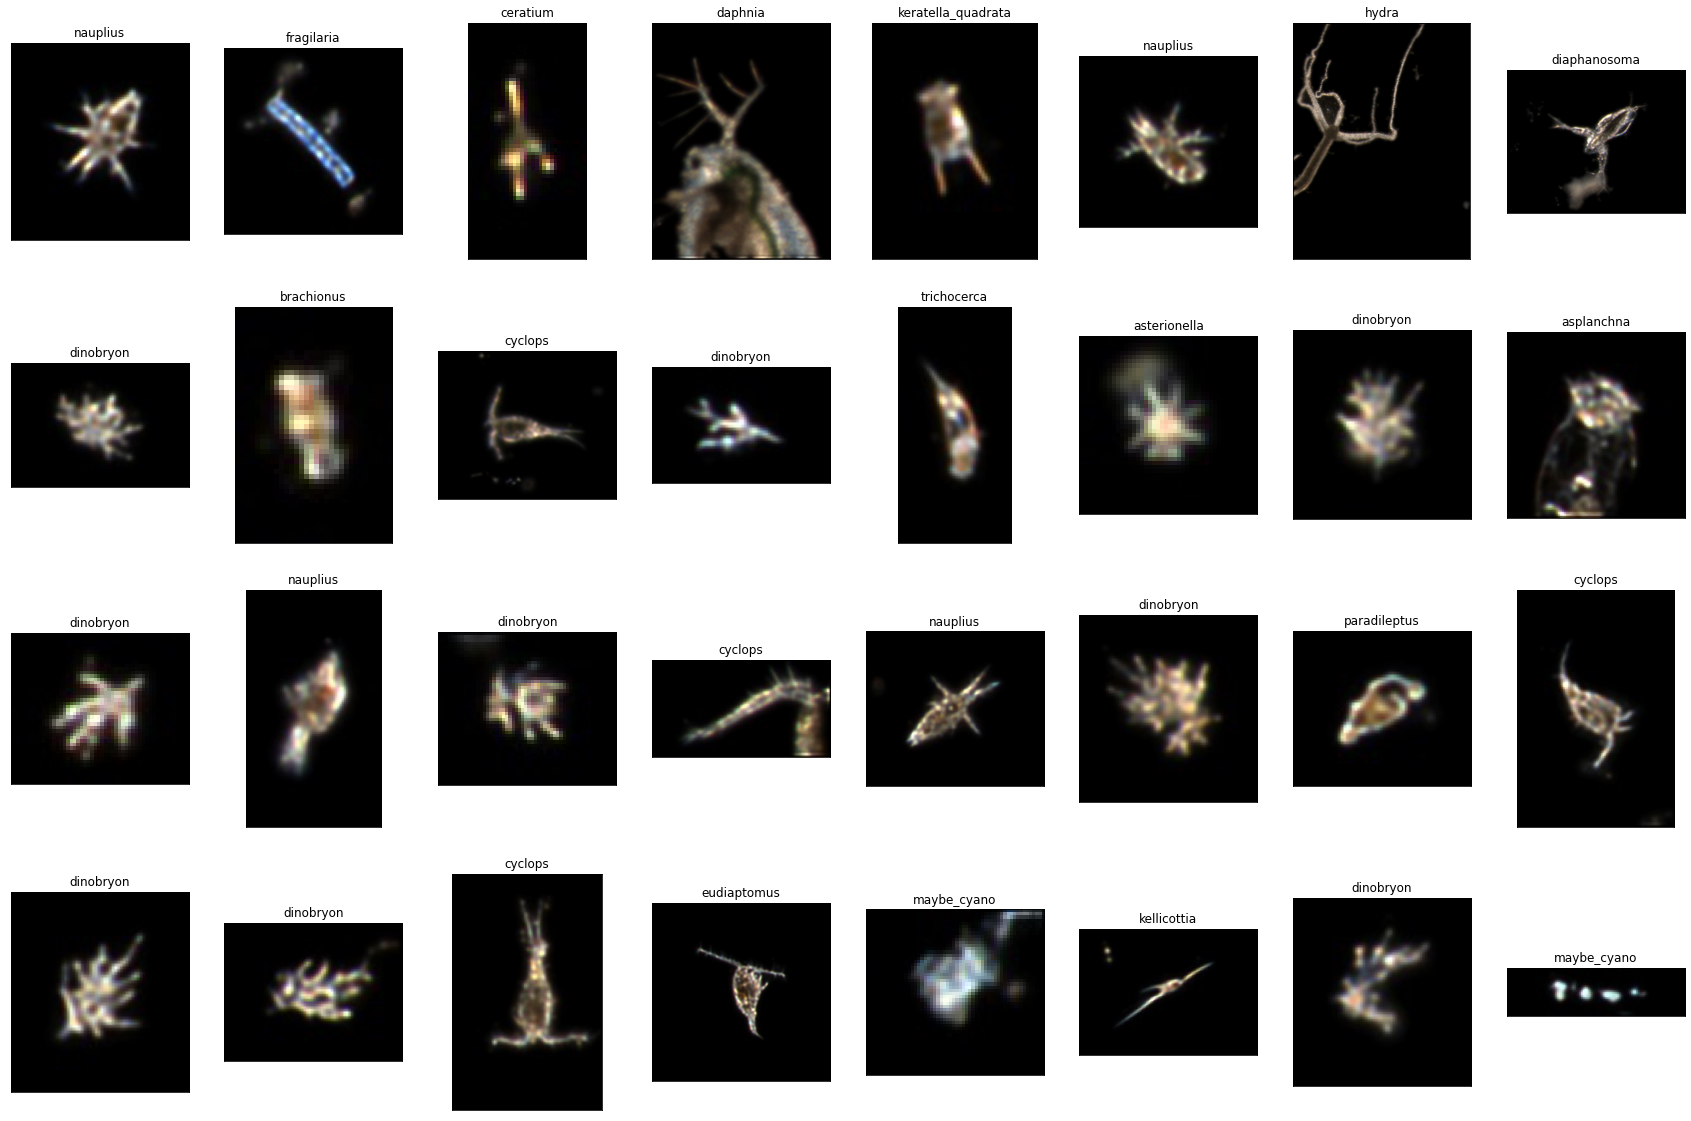

In [5]:
# show some random images in training set

plt.figure(figsize=(30, 20))
for i in range(32):
    row_df = X_train_df.sample()
    label = row_df['labels'].to_list()[0]
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(load_img(row_df['filenames'].to_list()[0], color_mode='rgb', interpolation="nearest"))
    ax.set_title(label)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

# 2. Load image features (i.e., SIFT + k-means with k=512)

In [6]:
# SIFT + k-means (k=512) 

filepath_features_train = f"..//_inputs-Zoolake//_image_features//X-sift_512_std_features-train_df.csv"

filepath_features_validation = f"..//_inputs-Zoolake//_image_features//X-sift_512_std_features-validation_df.csv"

filepath_features_test = f"..//_inputs-Zoolake//_image_features//X-sift_512_std_features-test_df.csv"

X_daisy_train_df = pd.read_csv(filepath_features_train, header=None)
X_daisy_validation_df = pd.read_csv(filepath_features_validation, header=None)
X_daisy_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_daisy_train_df.head(5))
display(X_daisy_train_df.shape)
display(X_daisy_validation_df.head(5))
display(X_daisy_validation_df.shape)
display(X_daisy_test_df.head(5))
display(X_daisy_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,SPC-EAWAG-0P5X-1531357072113604-3071035817378-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,1.789814,0.962614,-0.287256,-0.291397,...,-0.236373,-0.255229,4.366009,-0.299415,-0.162362,-0.303492,3.424493,-0.17736,2.908325,-0.276084
1,SPC-EAWAG-0P5X-1541206751828599-6889252211507-...,2.018454,-0.276515,-0.294881,-0.200259,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
2,SPC-EAWAG-0P5X-1570496558527228-3678536917289-...,-0.217653,-0.276515,-0.294881,0.411719,-0.273915,-0.250621,-0.316171,2.565015,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
3,SPC-EAWAG-0P5X-1589436595239499-10182004143170...,-0.217653,0.383023,-0.294881,-0.558490,0.833639,-0.250621,-0.316171,0.490636,0.827547,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,1.417507,-0.276084
4,SPC-EAWAG-0P5X-1535891187935356-1573766176829-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.236373,-0.255229,5.628318,-0.299415,-0.162362,-0.303492,4.425083,-0.17736,-0.215294,-0.276084


(12560, 512)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,SPC-EAWAG-0P5X-1534683719885923-366314990681-0...,-0.217653,-0.276515,-0.294881,1.104725,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
1,SPC-EAWAG-0P5X-1529587196370427-1301184623330-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,2.114657,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
2,SPC-EAWAG-0P5X-1582020259445676-2765778499013-...,-0.217653,-0.276515,0.579305,-0.558490,0.815076,0.798094,-0.316171,-0.287256,-0.291397,...,-0.236373,0.966209,-0.178303,0.499169,-0.162362,0.295203,-0.177635,-0.17736,-0.215294,0.719090
3,SPC-EAWAG-0P5X-1540988828619417-6671332208848-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
4,SPC-EAWAG-0P5X-1570496431525132-3678409906731-...,-0.217653,-0.276515,-0.294881,3.023819,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084


(2691, 512)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,SPC-EAWAG-0P5X-1583758855489337-4504349216771-...,-0.217653,-0.276515,-0.294881,0.062444,0.592438,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
1,SPC-EAWAG-0P5X-1588766987401707-9512406599790-...,-0.217653,-0.276515,-0.294881,-0.176768,-0.273915,1.288068,-0.316171,-0.287256,-0.291397,...,1.292881,-0.255229,-0.178303,2.043972,-0.162362,-0.303492,-0.177635,-0.17736,6.851255,-0.276084
2,SPC-EAWAG-0P5X-1538874737500295-4557272801645-...,1.984574,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,1.177029,-0.255229,2.988945,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
3,SPC-EAWAG-0P5X-1563253441682165-10158811549619...,-0.217653,-0.276515,-0.294881,0.651121,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084
4,SPC-EAWAG-0P5X-1589472048491421-10217456883913...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,3.885551,-0.287256,-0.291397,...,-0.236373,-0.255229,-0.178303,-0.299415,-0.162362,-0.303492,-0.177635,-0.17736,-0.215294,-0.276084


(2692, 512)

In [7]:
# HOG + PCA (350) 

filepath_features_train = f"..//_inputs-Zoolake//_image_features//X-HOG_PCA_800_std_features-train_df.csv"

filepath_features_validation = f"..//_inputs-Zoolake//_image_features//X-HOG_PCA_800_std_features-validation_df.csv"

filepath_features_test = f"..//_inputs-Zoolake//_image_features//X-HOG_PCA_800_std_features-test_df.csv"

X_HOGPCA_train_df = pd.read_csv(filepath_features_train, header=None)
X_HOGPCA_validation_df = pd.read_csv(filepath_features_validation, header=None)
X_HOGPCA_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_HOGPCA_train_df.head(5))
display(X_HOGPCA_train_df.shape)
display(X_HOGPCA_validation_df.head(5))
display(X_HOGPCA_validation_df.shape)
display(X_HOGPCA_test_df.head(5))
display(X_HOGPCA_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,800
0,SPC-EAWAG-0P5X-1531357072113604-3071035817378-...,-2.082264,-1.134444,2.090079,1.306375,-0.910367,-1.011474,0.541974,1.858517,-0.895307,...,-0.561276,0.458865,-1.088508,0.517656,-1.287641,0.332483,1.140772,-0.474564,-1.030179,-1.729629
1,SPC-EAWAG-0P5X-1541206751828599-6889252211507-...,-0.433534,-0.715758,0.415551,0.970226,-1.253622,-0.137044,-0.044419,1.443093,1.149475,...,-0.498806,0.970535,-1.499156,0.797924,1.129200,1.009784,1.115630,-0.831115,-1.367936,-1.261256
2,SPC-EAWAG-0P5X-1570496558527228-3678536917289-...,-0.232103,1.020065,0.796629,-0.926632,-1.272004,0.783327,0.494485,0.389713,0.893414,...,0.800759,-1.123802,-0.031864,-0.754997,-0.882215,-2.348427,-1.252453,-1.084055,-0.452147,-1.539950
3,SPC-EAWAG-0P5X-1589436595239499-10182004143170...,0.827571,-1.573192,1.368723,-0.000174,3.640084,0.310122,1.029367,-0.556042,0.098141,...,1.157126,1.189158,-0.814440,-0.141829,-0.132871,-0.070254,-0.207117,-0.005864,1.080433,1.195661
4,SPC-EAWAG-0P5X-1535891187935356-1573766176829-...,-0.236444,-0.176593,0.336320,-1.782854,0.574230,-0.288512,-0.058137,1.081831,1.205424,...,-0.403546,-0.829209,-0.665964,0.040319,-0.390000,0.413303,-0.781793,0.210624,-0.530161,-1.237302


(12560, 801)

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,800
0,SPC-EAWAG-0P5X-1534683719885923-366314990681-0...,-0.619699,0.940942,1.243141,0.290549,-1.083961,0.739664,-0.459175,-0.635640,-1.191493,...,-0.757808,-0.988786,1.833469,-1.006002,0.512076,1.217273,0.177060,-0.618450,0.493095,1.452511
1,SPC-EAWAG-0P5X-1529587196370427-1301184623330-...,-0.349005,-1.514082,0.284121,-0.133890,0.823152,-0.796563,-0.409829,2.384929,1.352401,...,0.201270,1.319867,-1.903200,2.733302,-0.817124,-0.017255,-1.702747,-0.493251,-0.345497,0.321036
2,SPC-EAWAG-0P5X-1582020259445676-2765778499013-...,-0.726354,-1.784628,1.192261,-0.138306,-1.457833,1.250248,2.179215,0.128221,-1.186870,...,-0.760394,0.950276,-3.140240,-0.051602,0.872460,-0.581309,-0.317760,-0.058088,0.615750,-0.987117
3,SPC-EAWAG-0P5X-1540988828619417-6671332208848-...,-0.913085,0.063167,0.612994,-0.901081,-0.537720,0.238847,-1.175579,1.515231,1.869155,...,-0.112769,-0.544333,0.321381,0.845863,0.072830,-1.303197,0.393529,2.009852,-0.044469,-0.628902
4,SPC-EAWAG-0P5X-1570496431525132-3678409906731-...,0.727039,1.261845,0.854315,-0.107160,0.871934,1.392448,-0.237767,0.870078,0.362650,...,0.163215,1.254518,-0.220020,1.114178,-1.779833,-0.619330,0.177670,1.113085,-0.824217,-0.154611


(2691, 801)

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,800
0,SPC-EAWAG-0P5X-1583758855489337-4504349216771-...,-1.598783,-0.342310,1.593694,0.621187,0.255863,-0.707275,0.087005,1.606806,-0.957585,...,-1.032550,-0.196846,0.675264,1.023790,0.058770,-0.927986,0.733562,-1.461818,0.022410,-0.616741
1,SPC-EAWAG-0P5X-1588766987401707-9512406599790-...,0.960039,-0.946996,1.552668,-0.212576,0.615044,3.357349,0.790496,-0.628991,1.992241,...,-1.293497,-0.323230,-0.973236,1.887282,2.192820,-0.454952,0.798697,-0.591924,-0.489666,-0.341585
2,SPC-EAWAG-0P5X-1538874737500295-4557272801645-...,-1.190995,-0.311619,-1.756219,-0.342260,0.516657,0.267081,0.326622,-0.571863,0.702685,...,0.287602,-0.704034,0.761975,0.373754,-0.410463,0.664757,-0.186747,0.958558,-0.136095,-0.296921
3,SPC-EAWAG-0P5X-1563253441682165-10158811549619...,-0.497375,0.905950,-1.382732,-0.376697,1.044219,-1.329422,0.953710,-1.147930,0.395916,...,-0.495348,-0.200394,-1.253199,-1.526513,0.685841,0.064510,-0.943806,-0.045393,0.468668,-0.298053
4,SPC-EAWAG-0P5X-1589472048491421-10217456883913...,0.417962,0.370122,-0.146781,-1.366441,0.818684,-0.046911,-1.493979,1.000865,0.131160,...,0.057207,0.122768,0.104215,-0.875783,0.180984,1.049402,0.686767,-0.547297,1.484994,1.515345


(2692, 801)

In [8]:
# LBP + PCA (k=35) 

filepath_features_train = f"..//_inputs-Zoolake//_image_features//X-LBP_PCA_15_std_features-train_df.csv"

filepath_features_validation = f"..//_inputs-Zoolake//_image_features//X-LBP_PCA_15_std_features-validation_df.csv"

filepath_features_test = f"..//_inputs-Zoolake//_image_features//X-LBP_PCA_15_std_features-test_df.csv"

X_LBPPCA_train_df = pd.read_csv(filepath_features_train, header=None)
X_LBPPCA_validation_df = pd.read_csv(filepath_features_validation, header=None)
X_LBPPCA_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_LBPPCA_train_df.head(5))
display(X_LBPPCA_train_df.shape)
display(X_LBPPCA_validation_df.head(5))
display(X_LBPPCA_validation_df.shape)
display(X_LBPPCA_test_df.head(5))
display(X_LBPPCA_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,SPC-EAWAG-0P5X-1531357072113604-3071035817378-...,0.611904,-3.196214,2.972455,-1.507909,-0.864207,-1.509528,1.311930,1.026875,1.852103,-1.446336,0.170413,-0.835770,-1.106186,1.958650,-2.150590
1,SPC-EAWAG-0P5X-1541206751828599-6889252211507-...,1.255804,0.121074,0.728287,-1.064518,0.650390,-0.622585,2.710702,3.791819,0.425358,1.856845,-0.845126,-2.349697,0.649562,-1.666562,0.642532
2,SPC-EAWAG-0P5X-1570496558527228-3678536917289-...,-1.163229,0.324766,0.916609,-0.952890,0.563541,1.284754,0.059589,0.539029,-0.664569,0.572566,0.739119,-0.531457,-1.293548,-0.556876,1.110624
3,SPC-EAWAG-0P5X-1589436595239499-10182004143170...,1.362830,2.778092,0.722970,4.072050,-0.165178,-1.868290,-0.595049,0.159691,0.641576,-1.397467,2.932505,-1.879710,-0.123685,-2.509644,0.216036
4,SPC-EAWAG-0P5X-1535891187935356-1573766176829-...,0.673319,-0.234903,-0.383429,0.585706,-0.181157,2.105548,1.228878,2.259009,-0.213074,1.121169,2.176062,-0.419735,0.918199,0.876810,0.173197


(12560, 16)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,SPC-EAWAG-0P5X-1534683719885923-366314990681-0...,-1.360433,-0.117052,1.258528,0.326426,0.605378,1.435783,-0.707744,-0.068006,0.128780,1.340313,-0.851227,-0.706350,-0.316229,1.064883,-0.574748
1,SPC-EAWAG-0P5X-1529587196370427-1301184623330-...,1.435743,0.018620,-0.361753,-0.158634,-0.218187,-0.762006,0.534346,2.074798,0.238147,0.610857,-0.635034,0.679275,-0.709614,-0.234263,-0.496649
2,SPC-EAWAG-0P5X-1582020259445676-2765778499013-...,2.276692,0.376623,2.829918,0.089438,0.714801,0.781968,2.021016,-0.065391,0.098512,0.460538,0.176559,0.631254,2.272717,0.991090,-0.145105
3,SPC-EAWAG-0P5X-1540988828619417-6671332208848-...,-0.950937,-0.729821,0.512591,-1.258072,0.732116,0.620700,-0.904182,1.095913,-0.058721,-1.423612,-0.938955,1.399896,0.237249,-0.212569,-0.241002
4,SPC-EAWAG-0P5X-1570496431525132-3678409906731-...,-1.260860,0.477870,0.852200,0.309171,0.640694,0.943973,0.687883,0.278400,-0.618854,-0.366484,-0.033278,1.220026,-1.019305,-0.009781,0.459571


(2691, 16)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,SPC-EAWAG-0P5X-1583758855489337-4504349216771-...,0.795438,-1.245393,1.271884,-0.360005,-0.125068,-1.240231,2.516488,-0.217642,-0.266376,-1.370656,-0.892043,-0.502878,0.968679,1.813115,-0.862598
1,SPC-EAWAG-0P5X-1588766987401707-9512406599790-...,0.297089,1.755234,-0.530818,1.162501,4.555128,1.569589,-0.832047,-0.270167,1.385578,0.381364,3.261857,-2.104295,-2.113781,-2.392457,3.044705
2,SPC-EAWAG-0P5X-1538874737500295-4557272801645-...,0.802665,-1.059073,-1.122496,0.310592,-0.244847,-0.013609,0.201010,0.198721,-0.211740,1.176847,0.508149,-0.360525,-0.891319,-0.190134,0.536898
3,SPC-EAWAG-0P5X-1563253441682165-10158811549619...,0.037954,-0.700924,-0.759317,0.371510,-1.298112,0.084598,-0.475606,-0.675424,-0.812223,0.488414,0.080142,-0.155564,0.288649,-1.626228,-0.055590
4,SPC-EAWAG-0P5X-1589472048491421-10217456883913...,-0.933219,0.641733,-0.140010,0.349152,0.058285,0.341654,0.655588,0.580653,0.684827,-1.909089,0.029999,0.330945,0.711873,-0.146369,-0.217870


(2692, 16)

In [9]:
# Gabor filters (96)

filepath_features_train = f"..//_inputs-Zoolake//_image_features//X-Gabor_96_std_features-train_df.csv"

filepath_features_validation = f"..//_inputs-Zoolake//_image_features//X-Gabor_96_std_features-validation_df.csv"

filepath_features_test = f"..//_inputs-Zoolake//_image_features//X-Gabor_96_std_features-test_df.csv"

X_gabor_train_df = pd.read_csv(filepath_features_train, header=None)
X_gabor_validation_df = pd.read_csv(filepath_features_validation, header=None)
X_gabor_test_df = pd.read_csv(filepath_features_test, header=None)

display(X_gabor_train_df.head(5))
display(X_gabor_train_df.shape)
display(X_gabor_validation_df.head(5))
display(X_gabor_validation_df.shape)
display(X_gabor_test_df.head(5))
display(X_gabor_test_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,SPC-EAWAG-0P5X-1531357072113604-3071035817378-...,1.846770,0.248282,1.940620,0.362548,1.909330,0.535886,1.404890,0.445636,0.962934,...,-1.277320,-0.712519,-0.951254,-0.341912,-0.535800,0.065581,-0.255850,1.076660,-0.260917,0.314049
1,SPC-EAWAG-0P5X-1541206751828599-6889252211507-...,0.237756,0.249621,0.217094,0.274385,0.172624,-0.145054,0.548313,0.371051,0.675236,...,-0.057827,0.140471,0.611669,0.357953,-0.369505,-0.700624,-0.982313,0.309374,-0.803206,1.427530
2,SPC-EAWAG-0P5X-1570496558527228-3678536917289-...,-0.278729,0.082286,-0.321584,-0.112572,-0.510213,-0.484915,-0.818950,-0.998868,-0.805014,...,0.137208,1.600020,-0.008706,0.877450,-1.046760,0.181285,-0.713228,-0.687470,0.424877,-0.484348
3,SPC-EAWAG-0P5X-1589436595239499-10182004143170...,1.704340,1.584810,1.615060,1.382580,1.626930,1.206110,1.427410,0.498986,1.327150,...,-0.722699,0.449907,-0.157474,1.032120,-1.106940,-0.492541,-1.109110,-0.575418,-1.098150,0.050437
4,SPC-EAWAG-0P5X-1535891187935356-1573766176829-...,-0.238733,-0.085194,-0.305752,-0.219342,-0.168847,-0.448465,0.332381,-0.097950,0.855046,...,-0.619922,-0.438089,1.167360,0.621815,-0.384684,0.792777,-0.276352,1.071720,-0.641504,1.091630


(12560, 97)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,SPC-EAWAG-0P5X-1534683719885923-366314990681-0...,0.049790,1.350880,-0.119312,0.845034,-0.609528,-0.249951,-1.099060,-1.249690,-1.203280,...,-1.671330,-1.065660,-1.028690,-0.462429,0.455217,1.601200,1.228000,1.453580,1.206410,1.103740
1,SPC-EAWAG-0P5X-1529587196370427-1301184623330-...,0.291881,0.265374,0.267174,0.311907,0.357788,0.414009,0.522536,0.276420,0.634771,...,-0.168340,0.188825,0.254166,-0.161441,-0.483393,-0.369912,-0.744297,0.975133,-1.012320,0.621918
2,SPC-EAWAG-0P5X-1582020259445676-2765778499013-...,0.647758,0.765118,0.680281,0.931605,0.652673,1.184590,0.408980,0.289542,0.380839,...,1.293490,0.943685,2.147810,1.654740,-0.840072,-0.704957,-1.877780,-1.601440,-2.317070,-1.465540
3,SPC-EAWAG-0P5X-1540988828619417-6671332208848-...,-0.768659,-0.785363,-0.784956,-0.734228,-0.907476,-0.803540,-1.114000,-1.275980,-1.150310,...,-0.749460,-0.057692,0.086865,-0.061399,0.792023,1.621660,0.877522,1.251180,0.718342,0.635597
4,SPC-EAWAG-0P5X-1570496431525132-3678409906731-...,-0.632436,-0.540626,-0.573331,-0.099314,-0.612834,0.351209,-0.948852,-0.336358,-1.150120,...,0.874215,0.794240,0.278202,0.214282,-1.065510,-1.200870,-0.220339,-0.135772,-0.047848,-0.447649


(2691, 97)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,SPC-EAWAG-0P5X-1583758855489337-4504349216771-...,0.743012,1.681820,0.614689,1.122550,0.489177,0.446153,0.367398,0.330275,0.376911,...,-1.533100,-0.270024,-0.702602,0.404377,-0.158804,0.248742,-0.088516,0.188836,0.566446,3.012010
1,SPC-EAWAG-0P5X-1588766987401707-9512406599790-...,2.528730,1.536170,2.600290,1.736770,2.439430,1.922570,1.650210,0.724073,1.044470,...,-0.609073,0.437355,-0.796294,0.918383,-1.543160,-0.406933,-1.413440,-2.212060,-0.966673,-0.984239
2,SPC-EAWAG-0P5X-1538874737500295-4557272801645-...,0.353835,0.808291,0.375663,0.785264,0.463863,0.448579,0.613699,-0.180915,1.082390,...,-0.831794,0.074186,0.324359,0.470126,-0.566168,-0.074288,-0.696955,0.484709,-0.675917,0.737283
3,SPC-EAWAG-0P5X-1563253441682165-10158811549619...,0.211715,0.847624,0.249244,1.042330,0.304468,1.023750,0.437003,0.490730,0.381918,...,-0.020757,1.842160,0.540806,1.143950,0.805012,0.938018,0.305025,0.140123,-0.120701,0.325302
4,SPC-EAWAG-0P5X-1589472048491421-10217456883913...,-0.770793,-0.024543,-0.824745,-0.277367,-1.048610,-0.979003,-1.152260,-1.274080,-1.211770,...,-0.564173,0.227127,-2.024830,-1.607060,-0.565543,-0.273987,0.659305,1.161370,1.509580,0.806315


(2692, 97)

In [10]:
# merge image features into an unique feature vector for each set

# training set
X_features_train_df = pd.concat([X_daisy_train_df, 
                                 X_HOGPCA_train_df.loc[:,1:],
                                 X_gabor_train_df.loc[:,1:],
                                 X_LBPPCA_train_df.loc[:,1:]], axis=1)

X_features_train_df.columns = range(len(X_features_train_df.columns))   # reset column indexes    

display(X_features_train_df.head(5))
display(X_features_train_df.shape)   



# validation set
X_features_validation_df = pd.concat([X_daisy_validation_df, 
                                 X_HOGPCA_validation_df.loc[:,1:],
                                 X_gabor_validation_df.loc[:,1:],
                                 X_LBPPCA_validation_df.loc[:,1:]], axis=1)

X_features_validation_df.columns = range(len(X_features_validation_df.columns))   # reset column indexes   
                                            
display(X_features_validation_df.head(5))
display(X_features_validation_df.shape)  


# test set
X_features_test_df = pd.concat([X_daisy_test_df, 
                                 X_HOGPCA_test_df.loc[:,1:],
                                 X_gabor_test_df.loc[:,1:],
                                 X_LBPPCA_test_df.loc[:,1:]], axis=1)
                                            
X_features_test_df.columns = range(len(X_features_test_df.columns))   # reset column indexes   

display(X_features_test_df.head(5))
display(X_features_test_df.shape)   


,0,1,2,3,4,5,6,7,8,9,...,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422
0,SPC-EAWAG-0P5X-1531357072113604-3071035817378-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,1.789814,0.962614,-0.287256,-0.291397,...,-1.509528,1.311930,1.026875,1.852103,-1.446336,0.170413,-0.835770,-1.106186,1.958650,-2.150590
1,SPC-EAWAG-0P5X-1541206751828599-6889252211507-...,2.018454,-0.276515,-0.294881,-0.200259,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.622585,2.710702,3.791819,0.425358,1.856845,-0.845126,-2.349697,0.649562,-1.666562,0.642532
2,SPC-EAWAG-0P5X-1570496558527228-3678536917289-...,-0.217653,-0.276515,-0.294881,0.411719,-0.273915,-0.250621,-0.316171,2.565015,-0.291397,...,1.284754,0.059589,0.539029,-0.664569,0.572566,0.739119,-0.531457,-1.293548,-0.556876,1.110624
3,SPC-EAWAG-0P5X-1589436595239499-10182004143170...,-0.217653,0.383023,-0.294881,-0.558490,0.833639,-0.250621,-0.316171,0.490636,0.827547,...,-1.868290,-0.595049,0.159691,0.641576,-1.397467,2.932505,-1.879710,-0.123685,-2.509644,0.216036
4,SPC-EAWAG-0P5X-1535891187935356-1573766176829-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,2.105548,1.228878,2.259009,-0.213074,1.121169,2.176062,-0.419735,0.918199,0.876810,0.173197


(12560, 1423)

,0,1,2,3,4,5,6,7,8,9,...,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422
0,SPC-EAWAG-0P5X-1534683719885923-366314990681-0...,-0.217653,-0.276515,-0.294881,1.104725,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,1.435783,-0.707744,-0.068006,0.128780,1.340313,-0.851227,-0.706350,-0.316229,1.064883,-0.574748
1,SPC-EAWAG-0P5X-1529587196370427-1301184623330-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,2.114657,-0.291397,...,-0.762006,0.534346,2.074798,0.238147,0.610857,-0.635034,0.679275,-0.709614,-0.234263,-0.496649
2,SPC-EAWAG-0P5X-1582020259445676-2765778499013-...,-0.217653,-0.276515,0.579305,-0.558490,0.815076,0.798094,-0.316171,-0.287256,-0.291397,...,0.781968,2.021016,-0.065391,0.098512,0.460538,0.176559,0.631254,2.272717,0.991090,-0.145105
3,SPC-EAWAG-0P5X-1540988828619417-6671332208848-...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,0.620700,-0.904182,1.095913,-0.058721,-1.423612,-0.938955,1.399896,0.237249,-0.212569,-0.241002
4,SPC-EAWAG-0P5X-1570496431525132-3678409906731-...,-0.217653,-0.276515,-0.294881,3.023819,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,0.943973,0.687883,0.278400,-0.618854,-0.366484,-0.033278,1.220026,-1.019305,-0.009781,0.459571


(2691, 1423)

,0,1,2,3,4,5,6,7,8,9,...,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422
0,SPC-EAWAG-0P5X-1583758855489337-4504349216771-...,-0.217653,-0.276515,-0.294881,0.062444,0.592438,-0.250621,-0.316171,-0.287256,-0.291397,...,-1.240231,2.516488,-0.217642,-0.266376,-1.370656,-0.892043,-0.502878,0.968679,1.813115,-0.862598
1,SPC-EAWAG-0P5X-1588766987401707-9512406599790-...,-0.217653,-0.276515,-0.294881,-0.176768,-0.273915,1.288068,-0.316171,-0.287256,-0.291397,...,1.569589,-0.832047,-0.270167,1.385578,0.381364,3.261857,-2.104295,-2.113781,-2.392457,3.044705
2,SPC-EAWAG-0P5X-1538874737500295-4557272801645-...,1.984574,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,-0.013609,0.201010,0.198721,-0.211740,1.176847,0.508149,-0.360525,-0.891319,-0.190134,0.536898
3,SPC-EAWAG-0P5X-1563253441682165-10158811549619...,-0.217653,-0.276515,-0.294881,0.651121,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,...,0.084598,-0.475606,-0.675424,-0.812223,0.488414,0.080142,-0.155564,0.288649,-1.626228,-0.055590
4,SPC-EAWAG-0P5X-1589472048491421-10217456883913...,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,3.885551,-0.287256,-0.291397,...,0.341654,0.655588,0.580653,0.684827,-1.909089,0.029999,0.330945,0.711873,-0.146369,-0.217870


(2692, 1423)

In [11]:
train_features = X_features_train_df.copy(deep=True).iloc[:,1:]
train_labels = X_train_df['labels']

display(train_features.head(5), train_features.shape, type(train_features))
display(train_labels.head(5), train_labels.shape, type(train_labels))

train_features = train_features.to_numpy()
display(train_features[0:5], train_features.shape, type(train_features))

,1,2,3,4,5,6,7,8,9,10,...,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422
0,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,1.789814,0.962614,-0.287256,-0.291397,0.509856,...,-1.509528,1.311930,1.026875,1.852103,-1.446336,0.170413,-0.835770,-1.106186,1.958650,-2.150590
1,2.018454,-0.276515,-0.294881,-0.200259,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,-0.442962,...,-0.622585,2.710702,3.791819,0.425358,1.856845,-0.845126,-2.349697,0.649562,-1.666562,0.642532
2,-0.217653,-0.276515,-0.294881,0.411719,-0.273915,-0.250621,-0.316171,2.565015,-0.291397,-0.442962,...,1.284754,0.059589,0.539029,-0.664569,0.572566,0.739119,-0.531457,-1.293548,-0.556876,1.110624
3,-0.217653,0.383023,-0.294881,-0.558490,0.833639,-0.250621,-0.316171,0.490636,0.827547,0.055102,...,-1.868290,-0.595049,0.159691,0.641576,-1.397467,2.932505,-1.879710,-0.123685,-2.509644,0.216036
4,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,-0.442962,...,2.105548,1.228878,2.259009,-0.213074,1.121169,2.176062,-0.419735,0.918199,0.876810,0.173197


(12560, 1422)

pandas.core.frame.DataFrame

0        cyclops
1        cyclops
2    maybe_cyano
3        daphnia
4        cyclops
Name: labels, dtype: object

(12560,)

pandas.core.series.Series

array([[-0.2176527 , -0.27651451, -0.29488131, ..., -1.10618557,
         1.95864963, -2.15058973],
       [ 2.01845448, -0.27651451, -0.29488131, ...,  0.64956219,
        -1.66656172,  0.64253198],
       [-0.2176527 , -0.27651451, -0.29488131, ..., -1.29354794,
        -0.556876  ,  1.1106245 ],
       [-0.2176527 ,  0.38302284, -0.29488131, ..., -0.12368535,
        -2.50964423,  0.21603596],
       [-0.2176527 , -0.27651451, -0.29488131, ...,  0.91819898,
         0.87680959,  0.1731968 ]])

(12560, 1422)

numpy.ndarray

In [12]:
validation_features = X_features_validation_df.copy(deep=True).iloc[:,1:]
validation_labels = X_validation_df['labels']

display(validation_features.head(5), validation_features.shape, type(validation_features))
display(validation_labels.head(5), validation_labels.shape, type(validation_labels))

validation_features = validation_features.to_numpy()
display(validation_features[0:5], validation_features.shape, type(validation_features))

,1,2,3,4,5,6,7,8,9,10,...,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422
0,-0.217653,-0.276515,-0.294881,1.104725,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,4.253069,...,1.435783,-0.707744,-0.068006,0.128780,1.340313,-0.851227,-0.706350,-0.316229,1.064883,-0.574748
1,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,2.114657,-0.291397,1.863861,...,-0.762006,0.534346,2.074798,0.238147,0.610857,-0.635034,0.679275,-0.709614,-0.234263,-0.496649
2,-0.217653,-0.276515,0.579305,-0.558490,0.815076,0.798094,-0.316171,-0.287256,-0.291397,-0.198103,...,0.781968,2.021016,-0.065391,0.098512,0.460538,0.176559,0.631254,2.272717,0.991090,-0.145105
3,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,2.213379,...,0.620700,-0.904182,1.095913,-0.058721,-1.423612,-0.938955,1.399896,0.237249,-0.212569,-0.241002
4,-0.217653,-0.276515,-0.294881,3.023819,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,1.242793,...,0.943973,0.687883,0.278400,-0.618854,-0.366484,-0.033278,1.220026,-1.019305,-0.009781,0.459571


(2691, 1422)

pandas.core.frame.DataFrame

0       ceratium
1    eudiaptomus
2    eudiaptomus
3       ceratium
4    maybe_cyano
Name: labels, dtype: object

(2691,)

pandas.core.series.Series

array([[-0.2176527 , -0.27651451, -0.29488131, ..., -0.31622872,
         1.06488348, -0.57474838],
       [-0.2176527 , -0.27651451, -0.29488131, ..., -0.70961431,
        -0.23426314, -0.49664919],
       [-0.2176527 , -0.27651451,  0.57930525, ...,  2.27271672,
         0.9910899 , -0.14510532],
       [-0.2176527 , -0.27651451, -0.29488131, ...,  0.23724865,
        -0.21256884, -0.24100171],
       [-0.2176527 , -0.27651451, -0.29488131, ..., -1.01930533,
        -0.00978065,  0.45957084]])

(2691, 1422)

numpy.ndarray

In [13]:
test_features = X_features_test_df.copy(deep=True).iloc[:,1:]
test_labels = X_test_df['labels']

display(test_features.head(5), test_features.shape, type(test_features))
display(test_labels.head(5), test_labels.shape, type(test_labels))

test_features = test_features.to_numpy()
display(test_features[0:5], test_features.shape, type(test_features))

,1,2,3,4,5,6,7,8,9,10,...,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422
0,-0.217653,-0.276515,-0.294881,0.062444,0.592438,-0.250621,-0.316171,-0.287256,-0.291397,0.725828,...,-1.240231,2.516488,-0.217642,-0.266376,-1.370656,-0.892043,-0.502878,0.968679,1.813115,-0.862598
1,-0.217653,-0.276515,-0.294881,-0.176768,-0.273915,1.288068,-0.316171,-0.287256,-0.291397,-0.442962,...,1.569589,-0.832047,-0.270167,1.385578,0.381364,3.261857,-2.104295,-2.113781,-2.392457,3.044705
2,1.984574,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,-0.442962,...,-0.013609,0.201010,0.198721,-0.211740,1.176847,0.508149,-0.360525,-0.891319,-0.190134,0.536898
3,-0.217653,-0.276515,-0.294881,0.651121,-0.273915,-0.250621,-0.316171,-0.287256,-0.291397,-0.442962,...,0.084598,-0.475606,-0.675424,-0.812223,0.488414,0.080142,-0.155564,0.288649,-1.626228,-0.055590
4,-0.217653,-0.276515,-0.294881,-0.558490,-0.273915,-0.250621,3.885551,-0.287256,-0.291397,-0.442962,...,0.341654,0.655588,0.580653,0.684827,-1.909089,0.029999,0.330945,0.711873,-0.146369,-0.217870


(2692, 1422)

pandas.core.frame.DataFrame

0      filament
1       daphnia
2    asplanchna
3      uroglena
4      ceratium
Name: labels, dtype: object

(2692,)

pandas.core.series.Series

array([[-0.2176527 , -0.27651451, -0.29488131, ...,  0.96867873,
         1.81311539, -0.86259789],
       [-0.2176527 , -0.27651451, -0.29488131, ..., -2.11378107,
        -2.39245722,  3.04470492],
       [ 1.98457407, -0.27651451, -0.29488131, ..., -0.89131856,
        -0.19013391,  0.5368981 ],
       [-0.2176527 , -0.27651451, -0.29488131, ...,  0.28864878,
        -1.6262284 , -0.05559041],
       [-0.2176527 , -0.27651451, -0.29488131, ...,  0.7118734 ,
        -0.14636864, -0.21787007]])

(2692, 1422)

numpy.ndarray

In [14]:
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(train_labels)

LabelBinarizer()

In [15]:
train_labels_encoded = jobs_encoder.transform(train_labels)
validation_labels_encoded = jobs_encoder.transform(validation_labels)
test_labels_encoded = jobs_encoder.transform(test_labels)

In [49]:
test_labels_encoded[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
display(train_labels_encoded[0:5], train_labels_encoded.shape, type(train_labels_encoded))
display(validation_labels_encoded[0:5], validation_labels_encoded.shape, type(validation_labels_encoded))
display(test_labels_encoded[0:5], test_labels_encoded.shape, type(test_labels_encoded))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

(12560, 35)

numpy.ndarray

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

(2691, 35)

numpy.ndarray

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

(2692, 35)

numpy.ndarray

# 4. Create model CNN + SIFT

## 4.1. Set metrics

In [17]:
# compute class weights
X_TRAINING_df = pd.concat([X_train_df, X_validation_df], ignore_index=True)
classes = X_TRAINING_df.sort_values(by=['labels']).groupby('labels').size().to_frame('number of images').reset_index()
# display(classes)

from scipy.stats.mstats import gmean
count = classes['number of images'].values
# display(count)

weights_PT = gmean(count) / count
#print(weights_PT)

weights_PT[weights_PT < 0.1] = 0.1
weights_PT[weights_PT > 10] = 10
#print(weights_PT)

class_weights_PT = dict(enumerate(weights_PT))
display(class_weights_PT)


{0: 1.0821789685078202,
 1: 0.4155735999922819,
 2: 0.23980793790330776,
 3: 3.230140254485464,
 4: 1.8378384206555225,
 5: 0.3116801999942114,
 6: 10.0,
 7: 0.9603119675497325,
 8: 7.895898399853356,
 9: 0.2969209704680231,
 10: 0.3500644610772424,
 11: 5.1997379706351365,
 12: 0.2297298025819403,
 13: 10.0,
 14: 0.1,
 15: 1.955864741248079,
 16: 0.46144860778363767,
 17: 0.6270272258707077,
 18: 1.158637265195873,
 19: 0.7866762243396332,
 20: 10.0,
 21: 0.4695798607842304,
 22: 2.1534268363236424,
 23: 0.6005331177353257,
 24: 1.2540544517414154,
 25: 0.18378384206555226,
 26: 0.16839593743763082,
 27: 0.5872982280882661,
 28: 3.1819292059110538,
 29: 0.3357311130646309,
 30: 1.8866305911154035,
 31: 0.9779323706240395,
 32: 1.0553923603764386,
 33: 3.5531542799340103,
 34: 0.26748965720958673}

In [18]:
from keras_tuner.tuners import BayesianOptimization, Hyperband
import keras_tuner

In [19]:
ROOT= f"..//_outputs"
MODEL_NAME = "EffB1"

TAGS = "juin2022"
index="sec6-ANN_imfeatures"

print("Hello! We are working with the CNN model:", MODEL_NAME)

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}//{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}//_Zooscan-{index}"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}//_{TAGS}_{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")



Hello! We are working with the CNN model: EffB1


In [20]:
display(LOGTIME_DIR)

'..//_outputs//EffB1//_Zooscan-sec6-ANN_imfeatures//_juin2022_20220730-083723'

In [21]:
early_stopping = EarlyStopping(patience=30, monitor='val_prc', min_delta=0.001, verbose=1, mode='max')

In [22]:
def reg_wrapper(type, value):
    if type == 'l2':
        return l2(value)

    
def build_model(hp):
    # image feature
    total_dim= 1422
    
    feature_input = Input(shape=(total_dim), name="image_features") 
    
    feature_network = feature_input
    
    reg1 = reg_wrapper('l2', hp.Choice('reg_value1', np.concatenate((np.arange(1,10,1)*1e-3, np.arange(1,10,1)*1e-4, np.arange(1,10,1)*1e-5, np.arange(1,10,1)*1e-6)).tolist(), default=0.001))
    reg2 = reg_wrapper('l2', hp.Choice('reg_value2', np.concatenate((np.arange(1,10,1)*1e-3, np.arange(1,10,1)*1e-4, np.arange(1,10,1)*1e-5, np.arange(1,10,1)*1e-6)).tolist(), default=0.001))
    
    # num_layers = hp.Int('num_of_layers', min_value=1, max_value=3, step=1, default=2)
    
    # for i in range(num_layers):
    feature_network = Dense(units=hp.Int('num_of_neurons_1', min_value=1024, max_value=4096, step=512, default=4096), kernel_regularizer=reg1, activation='relu')(feature_network)
    feature_network = Dropout(hp.Float('dropout_rate_1', min_value= 0, max_value=0.9, step=0.1, default=0.2))(feature_network)

    feature_network = Dense(units=hp.Int('num_of_neurons_2', min_value=512, max_value=1024, step=512, default=1024), kernel_regularizer=reg2, activation='relu')(feature_network)
    feature_network = Dropout(hp.Float('dropout_rate_2', min_value= 0, max_value=0.9, step=0.1, default=0.2))(feature_network)
    
    feature_network = Dense(512, activation='relu')(feature_network)
    
    classfier_layer = Dense(35, activation='softmax', name='classifier')(feature_network)
    
    model = Model(
                    inputs=feature_input,
                    outputs=classfier_layer
                    )
    
    model.compile(
                optimizer=Adam(3e-4),
                loss="categorical_crossentropy",
                # metrics=[keras.metrics.CategoricalAccuracy(name='accuracy'), keras.metrics.AUC(name='prc', curve='PR'),])
                metrics=[keras.metrics.AUC(name='prc', curve='PR')])
    
    return model


tuner = BayesianOptimization(
                                build_model,
                                objective = keras_tuner.Objective("val_prc", direction="max"),
                                max_trials=500,
                                seed=42,
                                directory=LOGTIME_DIR)



In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
reg_value1 (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.0001, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 1e-05, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 1e-06, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06], 'ordered': True}
reg_value2 (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.0001, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 1e-05, 2e-05, 3.0000000000000004e-05, 4e-05, 5e-05, 6.000000000000001e-05, 7.000000000000001e-05, 8e-05, 9e-05, 1e-06, 2e-06, 3e-06, 4e-06, 4.9999999999999996e-06, 6e-06, 7e-06, 8e-06, 9e-06], 'ordered': True}
nu

In [24]:
print("[INFO] performing hyperparameter search...")
tuner.search(
                x=train_features, y=train_labels_encoded,
                validation_data=(validation_features, validation_labels_encoded),
                batch_size=1000,
                callbacks=[early_stopping],
                class_weight=class_weights_PT,
                epochs=500
            )

Trial 500 Complete [00h 00m 47s]
val_prc: 0.9119569659233093

Best val_prc So Far: 0.9150280952453613
Total elapsed time: 07h 43m 54s
INFO:tensorflow:Oracle triggered exit


In [25]:
tuner.results_summary()

Results summary
Results in ..//_outputs//EffB1//_Zooscan-sec6-ANN_imfeatures//_juin2022_20220730-083723\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
reg_value1: 0.001
reg_value2: 0.001
num_of_neurons_1: 2048
dropout_rate_1: 0.7000000000000001
num_of_neurons_2: 1024
dropout_rate_2: 0.0
Score: 0.9150280952453613
Trial summary
Hyperparameters:
reg_value1: 0.001
reg_value2: 0.001
num_of_neurons_1: 2048
dropout_rate_1: 0.7000000000000001
num_of_neurons_2: 1024
dropout_rate_2: 0.0
Score: 0.9150233268737793
Trial summary
Hyperparameters:
reg_value1: 0.001
reg_value2: 0.001
num_of_neurons_1: 2048
dropout_rate_1: 0.7000000000000001
num_of_neurons_2: 1024
dropout_rate_2: 0.0
Score: 0.9149710536003113
Trial summary
Hyperparameters:
reg_value1: 0.001
reg_value2: 0.001
num_of_neurons_1: 2048
dropout_rate_1: 0.7000000000000001
num_of_neurons_2: 1024
dropout_rate_2: 0.0
Score: 0.9144543409347534
Trial summary
Hyperparameters:
reg_value1: 0.001
reg_value2: 0.001
num_of_neuron

In [26]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

In [28]:
print("[INFO] optimal number of dense layer: {}".format(bestHP.get("reg_value1")))
print("[INFO] optimal number of unites in dense layer: {}".format(bestHP.get("reg_value2")))
print("[INFO] optimal dropout rate: {}".format(bestHP.get("dropout_rate_1")))
print("[INFO] optimal dropout rate: {}".format(bestHP.get("dropout_rate_2")))
# print("[INFO] optimal learning rate: {:.4f}".format(bestHP.get("learning_rate")))

[INFO] optimal number of dense layer: 0.001
[INFO] optimal number of unites in dense layer: 0.001
[INFO] optimal dropout rate: 0.7000000000000001
[INFO] optimal dropout rate: 0.0


In [29]:
model = tuner.hypermodel.build(bestHP)

In [30]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_features (InputLayer)  [(None, 1422)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2914304   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
classifier (Dense)           (None, 35)               

In [32]:
def create_Callbakcs(strBestModelName):
    
    reduce_lr = ReduceLROnPlateau(monitor='val_prc',  mode='max', factor=0.2, min_delta=0.001, patience=10, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [reduce_lr, early_stopping, model_checkpoint]

MODEL_CHECKPOINTS = 'testing-best_model-fold.hdf5'

In [33]:
MODEL_CHECKPOINTS = 'testing-best_model-fold.hdf5'

In [34]:
model.fit(
            x=train_features, y=train_labels_encoded,
            validation_data=(validation_features, validation_labels_encoded),
            epochs=500, 
            batch_size=32,
            callbacks=create_Callbakcs(MODEL_CHECKPOINTS), 
            class_weight=class_weights_PT,
            verbose=1)

Epoch 1/500
382/393 [============================>.] - ETA: 0s - loss: 4.1480 - prc: 0.2941
Epoch 00001: val_prc improved from -inf to 0.64082, saving model to testing-best_model-fold.hdf5
393/393 [==============================] - 2s 5ms/step - loss: 4.1283 - prc: 0.3007 - val_loss: 4.0724 - val_prc: 0.6408
Epoch 2/500
391/393 [============================>.] - ETA: 0s - loss: 3.2100 - prc: 0.6716
Epoch 00002: val_prc improved from 0.64082 to 0.78249, saving model to testing-best_model-fold.hdf5
393/393 [==============================] - 2s 5ms/step - loss: 3.2100 - prc: 0.6718 - val_loss: 3.4335 - val_prc: 0.7825
Epoch 3/500
386/393 [============================>.] - ETA: 0s - loss: 2.6799 - prc: 0.8199
Epoch 00003: val_prc improved from 0.78249 to 0.82003, saving model to testing-best_model-fold.hdf5
393/393 [==============================] - 2s 5ms/step - loss: 2.6782 - prc: 0.8197 - val_loss: 3.0156 - val_prc: 0.8200
Epoch 4/500
388/393 [============================>.] - ETA: 0s -

In [35]:
print("Evaluate model on test data")
results = model.evaluate(test_features, test_labels_encoded, batch_size=32)
print("test loss, test acc:", results)

Evaluate model on test data
85/85 [==============================] - 0s 2ms/step - loss: 0.6892 - prc: 0.8960
test loss, test acc: [0.6892437934875488, 0.8959659934043884]


In [36]:
# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_features)
print("prediction shape:", prediction.shape)

Generate a prediction
prediction shape: (2692, 35)


In [37]:
prediction

array([[5.3284980e-06, 3.0354113e-12, 4.4691230e-11, ..., 1.7492996e-05,
        7.3674923e-06, 7.0934135e-12],
       [6.7748086e-05, 4.5844700e-04, 1.5905072e-06, ..., 8.1168953e-05,
        1.6842266e-03, 2.3987115e-05],
       [1.6235293e-06, 9.9632335e-01, 2.0633832e-09, ..., 1.8150815e-05,
        5.9495840e-05, 9.9898098e-06],
       ...,
       [1.1308776e-03, 9.9181361e-04, 1.7218902e-06, ..., 5.0036129e-02,
        2.0135834e-03, 2.7185089e-03],
       [3.5049798e-05, 3.2962333e-07, 2.7345585e-02, ..., 3.3462740e-05,
        3.6403694e-04, 1.7104506e-08],
       [1.0312297e-09, 2.7640124e-09, 7.5630835e-09, ..., 3.8603334e-09,
        2.4609557e-07, 2.1234719e-11]], dtype=float32)

In [39]:
test_pred = prediction.argmax(axis=1).tolist()

In [50]:
test_true_labels_encoded = test_labels_encoded.argmax(axis=1).tolist()

In [53]:
test_true_labels_encoded[1]

10

In [55]:
test_pred[1]

10

In [56]:
print(classification_report(test_true_labels_encoded, test_pred), sep='')

              precision    recall  f1-score   support

           0       0.61      0.79      0.69        28
           1       0.83      0.92      0.88        93
           2       0.89      0.87      0.88       165
           3       0.67      0.14      0.24        14
           4       0.68      0.62      0.65        21
           5       0.90      0.95      0.92       130
           6       1.00      0.50      0.67         2
           7       0.92      0.81      0.86        42
           8       0.25      0.33      0.29         6
           9       0.85      0.86      0.86       148
          10       0.83      0.86      0.84       112
          11       0.12      0.20      0.15         5
          12       0.88      0.95      0.91       161
          13       0.00      0.00      0.00         3
          14       0.88      0.92      0.90       446
          15       0.00      0.00      0.00        22
          16       0.83      0.85      0.84        75
          17       0.88    

C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [ ]:
test_pred = prediction.argmax(axis=1).tolist()
test_true = test_labels_encoded

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


## 5.2. Find the best learning rate bound (i.e., min - max learning rate)

In [29]:
path = os.path.abspath('learningRateFinder.py')
print(path)
spec = importlib.util.spec_from_file_location("learningRateFinder", path)
foo4 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo4)
foo4.LRFinder

C:\MyProjects\iPythonScripts\Plankton_zooscan\others_tests\_Zooscan-CNN_SIFT512-new\_pyscripts\learningRateFinder.py


learningRateFinder.LRFinder

In [31]:
del model
K.clear_session()
gc.collect()

7600

In [32]:
# load initial CNN model 

json_file = open(MODEL_ARCHITECHTURE_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)


# set calibration metric, optimization and loss function
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

OPTIMIZER = Adam()
    
LOSS = CategoricalCrossentropy()

model.load_weights(MODEL_WEIGHTS_INITIAL)


model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [33]:
lr_finder = foo4.LRFinder(model)
lr_finder.find(train_iterator,
               validation_iterator, 
               start_lr=1e-10, end_lr=1e-2, 
               class_weight=class_weights_PT,
               epochs=5)

Epoch 1/5
9/9 [==============================] - 112s 12s/step - loss: 1.0163 - accuracy: 0.0317 - prc: 0.0333 - val_loss: 3.2989 - val_accuracy: 0.0352 - val_prc: 0.0467
Epoch 2/5
9/9 [==============================] - 110s 12s/step - loss: 1.0155 - accuracy: 0.0313 - prc: 0.0333 - val_loss: 3.3109 - val_accuracy: 0.0435 - val_prc: 0.0458
Epoch 3/5
9/9 [==============================] - 115s 13s/step - loss: 1.0112 - accuracy: 0.0333 - prc: 0.0336 - val_loss: 3.3218 - val_accuracy: 0.0473 - val_prc: 0.0451
Epoch 4/5
9/9 [==============================] - 103s 11s/step - loss: 0.9875 - accuracy: 0.0348 - prc: 0.0346 - val_loss: 3.2153 - val_accuracy: 0.0823 - val_prc: 0.0624
Epoch 5/5
9/9 [==============================] - 107s 12s/step - loss: 0.7274 - accuracy: 0.2168 - prc: 0.1872 - val_loss: 6.5537 - val_accuracy: 0.3309 - val_prc: 0.2828


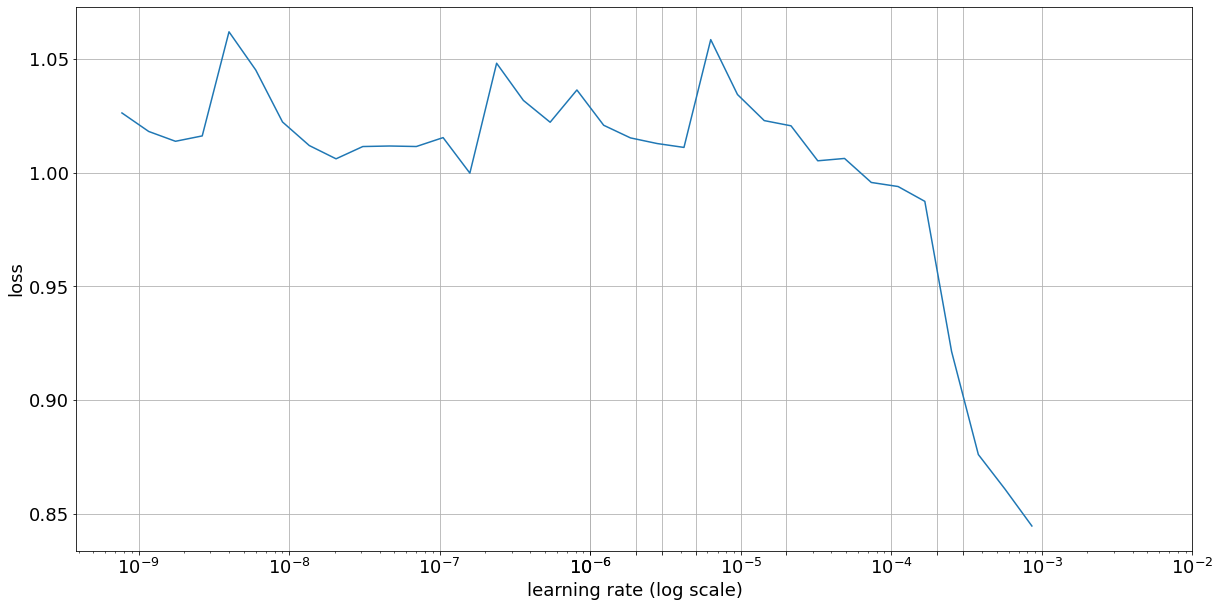

In [34]:
#1206
fig = plt.figure()
fig.set_size_inches(20,10, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=5, n_skip_end=5)

# ax = fig.gca()
plt.xticks([1e-9, 1e-8, 1e-7,1e-6,2e-6,3e-6,5e-6,1e-6,1e-5,2e-5,1e-4,2e-4,3e-4,1e-3,1e-2])
# 
# plt.xticks([1e-7, 1.7e-7])
plt.show()

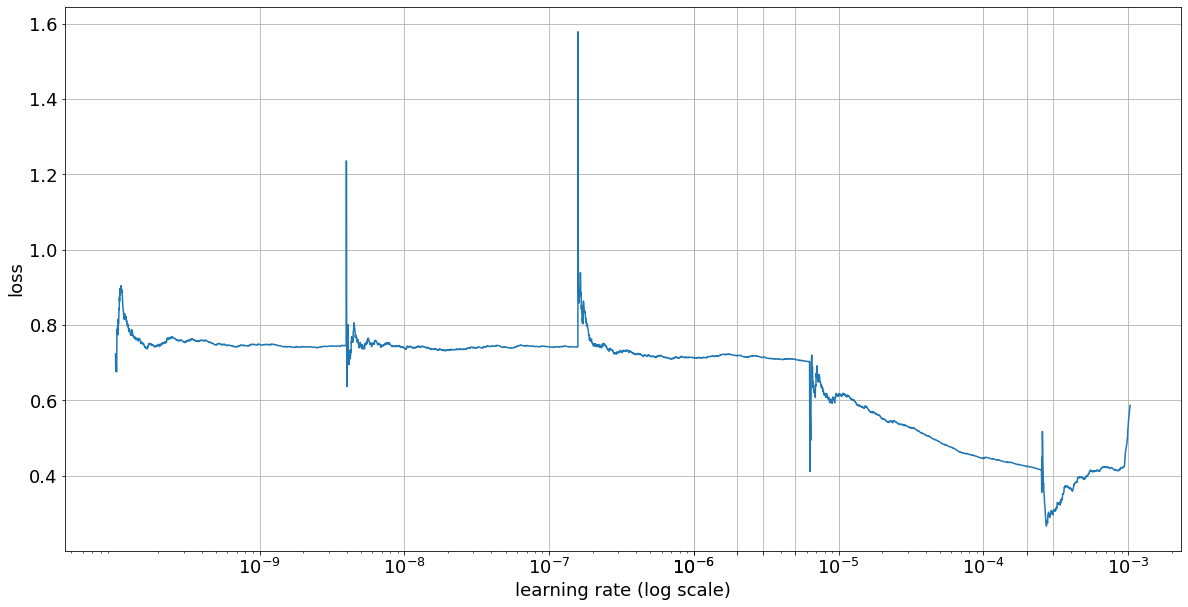

In [43]:
#1206
fig = plt.figure()
fig.set_size_inches(20,10, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=5, n_skip_end=850)

# ax = fig.gca()
plt.xticks([1e-9, 1e-8, 1e-7,1e-6,2e-6,3e-6,5e-6,1e-6,1e-5,1e-4,2e-4,3e-4,1e-3])
# 
# plt.xticks([1e-7, 1.7e-7])
plt.show()

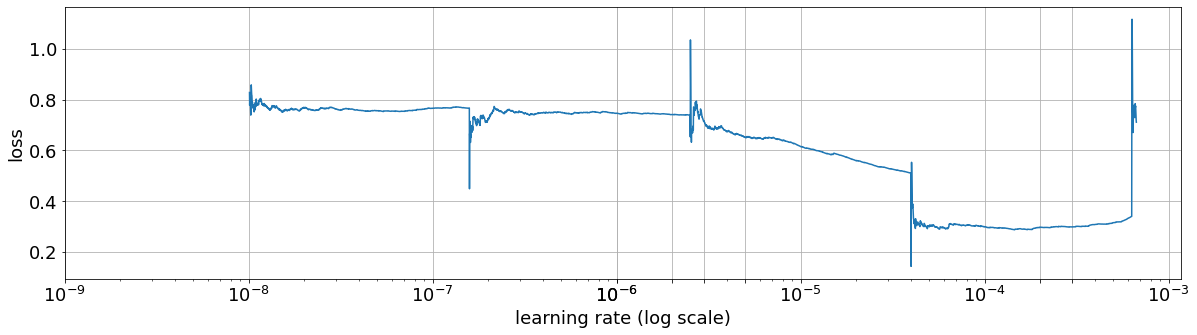

In [43]:
fig = plt.figure()
fig.set_size_inches(20,5, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=5, n_skip_end=1350)

# ax = fig.gca()
plt.xticks([1e-9, 1e-8, 1e-7,1e-6,2e-6,3e-6,5e-6,1e-6,1e-5,1e-4,2e-4,3e-4,1e-3])
# 
# plt.xticks([1e-7, 1.7e-7])
plt.show()

In [45]:
min_value = min(lr_finder.losses)
print(min_value)
min_index = lr_finder.losses.index(min_value)
print(min_index)
print(lr_finder.lrs[min_index])

2.5439395904541016
44
0.006640828


**Learning rate finder Cyclic Learning Rate; minimum learning rate boundary was 1e-7 and the maximum learning rate boundary was 1e-4 for our dataset**

### **5.3. Start to train the CNN**

In [35]:
del model
K.clear_session()
gc.collect()

4446

In [36]:
path = os.path.abspath('CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR


def create_Callbakcs(strBestModelName, steps_per_epoch):

    min_learningRate = 1e-05 # minimum learning rate
    max_learningRate = 1e-3  # maximum learning rate
    
    clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=4*steps_per_epoch, mode='triangular2')

    early_stopping = EarlyStopping(patience=20, monitor='val_prc', min_delta=0.001, verbose=1, mode='max') # calibration metric = "val+prc"
    model_checkpoint = ModelCheckpoint(strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [clr_triangular, early_stopping, model_checkpoint]

C:\MyProjects\iPythonScripts\Plankton_zooscan\others_tests\_Zooscan-CNN_SIFT512-new\_pyscripts\CyclicLR.py


In [37]:
all_history={}

fold='manual'

train_iterator = MyCustomImageDataGenerator(X_train_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                      datagen=train_gen, 
                                      feature_1_df=X_features_train_df, 
                                      batch_size=BATCH_SIZE, 
                                      shuffle=True,
                                     target_size=IMG_SIZE,
                                     color_mode= COLOR_MODE)

validation_iterator = MyCustomImageDataGenerator(X_validation_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                   datagen=validation_gen, 
                                      feature_1_df=X_features_validation_df, 
                                      batch_size=BATCH_SIZE, 
                                      shuffle=False,
                                     target_size=IMG_SIZE,
                                     color_mode= COLOR_MODE)

steps_per_epoch = train_iterator.__len__()


print("... Working at fold ", fold, "...")
print("\t step per epoch is: ", steps_per_epoch)


# load initial model
json_file = open(MODEL_ARCHITECHTURE_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

OPTIMIZER = Adam(learning_rate=1e-05)
    
LOSS = CategoricalCrossentropy()

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

print("\t 1. Reloading initial weights of the CNN model...")
model.load_weights(MODEL_WEIGHTS_INITIAL)

print("\t 1.1. Re-compiling the CNN model...")
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

print("\t 2. Starting training the model...")
start = time.time()

MODEL_CHECKPOINTS = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

myCallbacks = create_Callbakcs(strBestModelName=MODEL_CHECKPOINTS, steps_per_epoch = steps_per_epoch)

print("\t\t 2.1. Best model will be stored in the file: ", MODEL_CHECKPOINTS)

history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                epochs = MAX_EPOCHS,
                                callbacks=myCallbacks, 
                                class_weight=class_weights_PT,
                                verbose=0
                                )

time_done = time.time() - start

print("\t\t 2.2. Total time for training the CNN model in fold ", fold, "is: ", time_done, "seconds")

MODEL_TIME = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-TrainingTime-fold_{fold}.txt'
with open(MODEL_TIME, mode='w') as file:
    file.write('Total time for training the CNN model: %3f seconds.\n' %time_done)


MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_weights_final-fold_{fold}.hdf5'
print("\t\t 2.3. Model at final epoch will be stored in the file: ", MODEL_WEIGHTS_FINAL)
model.save_weights(MODEL_WEIGHTS_FINAL)


#save whole model at final epoch of training process
MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-model_final_epoch-fold_{fold}.hdf5'
print("\t\t 2.4. Model's weights at final epoch will be stored in the folder: ", MODEL_FINAL_EPOCH)
model.save(MODEL_FINAL_EPOCH)

# convert the history.history dict to a pandas DataFrame
# Save the history to CSV for further visualization
hist_df = pd.DataFrame(history_TLearning.history.copy()) 

HISTORY_CSV = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-History-fold_{fold}.csv'
print("\t\t 2.5. Learning curve of the model will be stored in the file: ", HISTORY_CSV)

with open(HISTORY_CSV, mode='w') as f:
    hist_df.to_csv(f)

print("... Ended fold ", fold, "...\n\n")

all_history[f'history-fold-{fold}'] = history_TLearning

Found 44099 image filenames belonging to 29 classes.
Found 14700 image filenames belonging to 29 classes.
... Working at fold  manual ...
	 step per epoch is:  9
	 1. Reloading initial weights of the CNN model...
	 1.1. Re-compiling the CNN model...
	 2. Starting training the model...
		 2.1. Best model will be stored in the file:  ..//_outputs//EffB1//_Zooscan-sec6-ANN_imfeatures//_juin2022_20220623-005602//EffB1_20220623-005602-best_model-fold_manual.hdf5

Epoch 00001: val_prc improved from -inf to 0.08438, saving model to ..//_outputs//EffB1//_Zooscan-sec6-ANN_imfeatures//_juin2022_20220623-005602\EffB1_20220623-005602-best_model-fold_manual.hdf5

Epoch 00002: val_prc improved from 0.08438 to 0.27681, saving model to ..//_outputs//EffB1//_Zooscan-sec6-ANN_imfeatures//_juin2022_20220623-005602\EffB1_20220623-005602-best_model-fold_manual.hdf5

Epoch 00003: val_prc improved from 0.27681 to 0.31718, saving model to ..//_outputs//EffB1//_Zooscan-sec6-ANN_imfeatures//_juin2022_20220623-0

# path = os.path.abspath('plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result

In [38]:
path = os.path.abspath('plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result

C:\MyProjects\iPythonScripts\Plankton_zooscan\others_tests\_Zooscan-CNN_SIFT512-new\_pyscripts\plot_result.py


<function plot_result.plot_result(folder, all_history)>

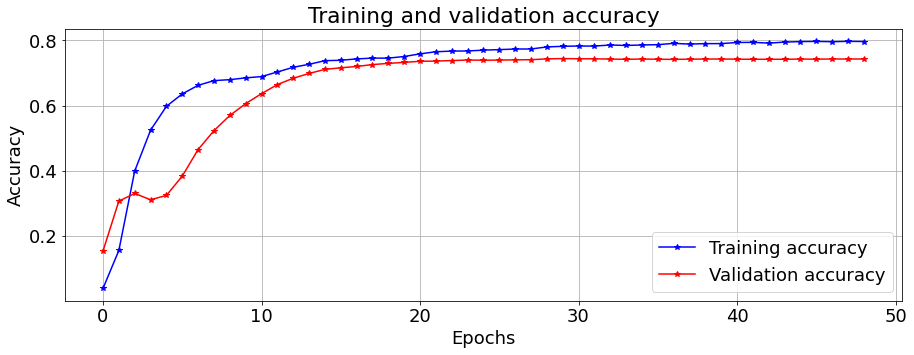

<Figure size 432x288 with 0 Axes>

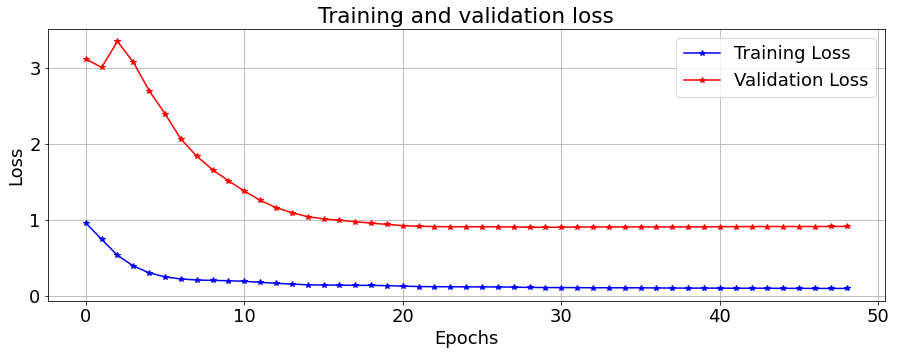

<Figure size 432x288 with 0 Axes>

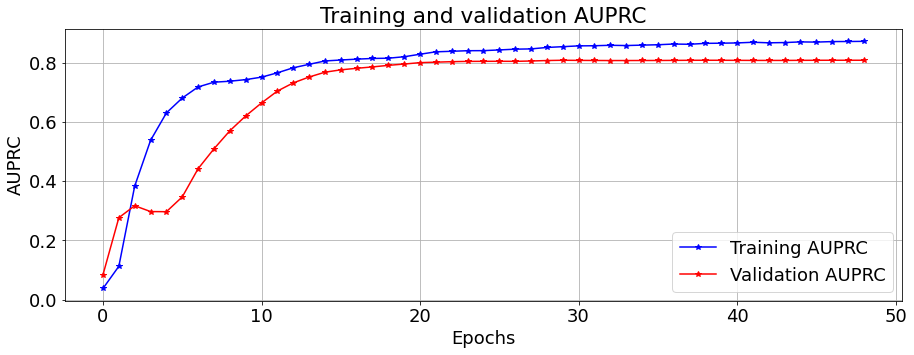

<Figure size 432x288 with 0 Axes>

In [39]:
foo2.plot_result(LOGTIME_DIR, all_history) 

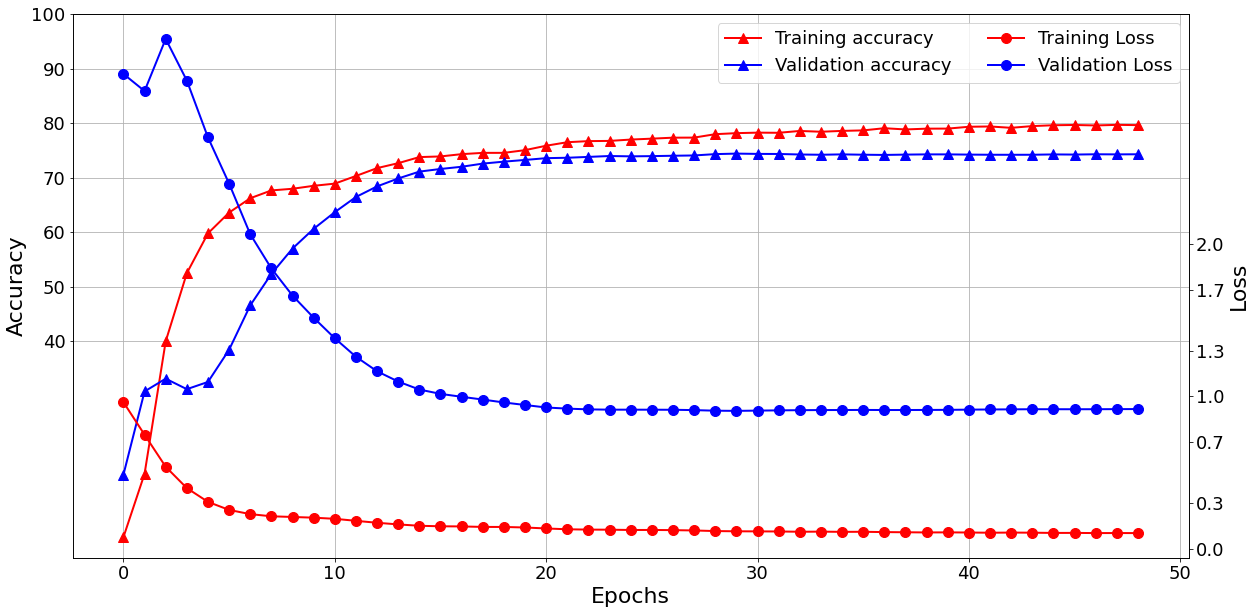

In [40]:
for index, history in enumerate(all_history):
        acc = np.array(all_history[history].history['accuracy'].copy())*100
        val_acc = np.array(all_history[history].history['val_accuracy'].copy())*100
        loss = all_history[history].history['loss'].copy()
        val_loss = all_history[history].history['val_loss'].copy()
        epochs = range(len(acc))

        # plt.figure(figsize=(15, 5))
        # plt.plot(epochs, acc, 'b*-', label='Training accuracy')
        # plt.plot(epochs, val_acc, 'r*-', label='Validation accuracy')
        # plt.grid()
        # plt.title('Training and validation accuracy')
        # plt.ylabel("Accuracy")
        # plt.xlabel("Epochs")
        # plt.legend()
        # # plt.savefig(f'{folder}/fold-{index+1}-acc.png')
        # plt.figure()
        # plt.show()
        
        markersize=10
        linewidth=2
        fontsize=22
        
        # create figure and axis objects with subplots()
        fig, ax1 = plt.subplots(figsize=(20, 10))
        # make a plot
        p1, = ax1.plot(epochs, acc, 'r^-', linewidth=linewidth, markersize=markersize, label='Training accuracy')
        p2, = ax1.plot(epochs, val_acc, 'b^-', linewidth=linewidth, markersize=markersize, label='Validation accuracy')
        # set x-axis label
        ax1.set_xlabel("Epochs",fontsize=fontsize)
        # set y-axis label
        ax1.set_ylabel("Accuracy",fontsize=fontsize)
        # ax.set_ylim([0, 100])
        
        # twin object for two different y-axis on the sample plot
        ax2 = ax1.twinx()
        # make a plot with different y-axis using second axis object
        p3, = ax2.plot(epochs, loss, 'ro-', linewidth=linewidth, markersize=markersize, label='Training Loss')
        p4, = ax2.plot(epochs, val_loss, 'bo-', linewidth=linewidth, markersize=markersize, label='Validation Loss')
        
        ax2.set_ylabel("Loss",fontsize=fontsize) 
        # ax2.set_ylim([0, 2])
        
        ax1.set_yticks(np.linspace(40, 100, 7),fontsize=fontsize)
        ax2.set_yticks(np.round(np.linspace(0, 2, 7),1), fontsize=fontsize)

        ax1.grid(), 
        # ax2.grid()
        # ax.legend()
        plt.legend(ncol=2, handles=[p1, p2,p3,p4],fontsize=fontsize-4)
        
        ax1.tick_params(axis='x', labelsize=fontsize-4)
        ax1.tick_params(axis='y', labelsize=fontsize-4)
        
        ax2.tick_params(axis='y', labelsize=fontsize-4)
        
#         for tick in ax1.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
#         for tick in ax1.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
#         for tick in ax2.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(fontsize) 
                
        plt.show()
        
        # save the plot as a file
        fig.savefig(f'{LOGTIME_DIR}/fold-{index+1}-accuracy_loss.jpg',
                    format='jpeg',
                    dpi=600,
                    bbox_inches='tight')

#         plt.figure(figsize=(15, 5))
#         loss = all_history[history].history['loss'].copy()
#         val_loss = all_history[history].history['val_loss'].copy()
#         plt.plot(epochs, loss, 'b*-', label='Training Loss')
#         plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
#         plt.grid()
#         plt.title('Training and validation loss')
#         plt.ylabel("Loss")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-loss.png')
#         plt.figure()
#         plt.show()
        
#         plt.figure(figsize=(15, 5))
#         prc = all_history[history].history['prc'].copy()
#         val_prc = all_history[history].history['val_prc'].copy()
#         plt.plot(epochs, prc, 'b*-', label='Training AUPRC')
#         plt.plot(epochs, val_prc, 'r*-', label='Validation AUPRC')
#         plt.grid()
#         plt.title('Training and validation AUPRC')
#         plt.ylabel("AUPRC")
#         plt.xlabel("Epochs")
#         plt.legend()
#         plt.savefig(f'{folder}/fold-{index+1}-AUPRC.png')
#         plt.figure()
#         plt.show()

# 5. Evaluate model

## 5.1 Evaluate on validation sets

In [38]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

path = os.path.abspath('plotConfusionMatrix.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_confusion_matrix", path)
foo5 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo5)
foo5.plot_confusion_matrix

from sklearn.metrics import balanced_accuracy_score, jaccard_score, average_precision_score, accuracy_score, recall_score

def calc_ClassBalancedAccuracy(confusion_matrix, classes_values, class_names): 
    result=0
    class_number = len(class_names)
    for i in classes_values:
        result += confusion_matrix[i][i] / max(sum(confusion_matrix[i,0:]), sum(confusion_matrix[0:,i]))

    result /= class_number
    
    return result


def computeGeometricAverageOfRecall(test_true, test_pred):
    result = 1.0
    for label in np.unique(test_true):
        idx = (test_true==label)
        result *= accuracy_score(np.array(test_true)[idx],np.array(test_pred)[idx])

    result = np.power(result, 1/len(np.unique(test_true)))

    return result


display(MODEL_CHECKPOINTS)

display(LOGTIME_DIR)

display(CNN_MODEL_NAME)

C:\MyProjects\iPythonScripts\Plankton_zooscan\others_tests\_Zoolake\_pyscripts\plotConfusionMatrix.py


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\MyProjects\\iPythonScripts\\Plankton_zooscan\\others_tests\\_Zoolake\\_pyscripts\\plotConfusionMatrix.py'

Found 6907 image filenames belonging to 29 classes.
Counter({5: 1052, 0: 1027, 6: 836, 19: 681, 7: 674, 26: 513, 14: 477, 27: 273, 8: 241, 2: 120, 22: 111, 28: 105, 13: 101, 3: 83, 16: 80, 24: 72, 15: 70, 20: 64, 4: 61, 23: 53, 1: 51, 25: 49, 17: 37, 9: 25, 10: 25, 18: 13, 12: 6, 21: 4, 11: 3})
['aggregats_debris', 'bivalvia', 'chaetognatha', 'cnidaria_and_fragments', 'cnidaria_siphonophorae', 'cop_calanoida', 'cop_cyclopoida_oithonoida', 'cop_cyclopoida_others', 'cop_harpacticoida', 'crust_amphipoda', 'crust_calyptopis', 'crust_cirripedia_larvae', 'crust_cladocera', 'crust_crustacea', 'crust_evadne_pseudevadne', 'crust_ostracoda', 'crust_penilia', 'crust_podon', 'echinodermata_larvae', 'fiber', 'fish_eggs', 'fish_larvae', 'nauplii', 'polychaeta', 'pter_cavolinidae', 'pter_limacinidae', 'tuni_appendicularia', 'tuni_appendicularia_tail', 'tuni_doliolida_salpida']
                           precision    recall  f1-score   support

         aggregats_debris       0.51      0.76      0.61 

C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

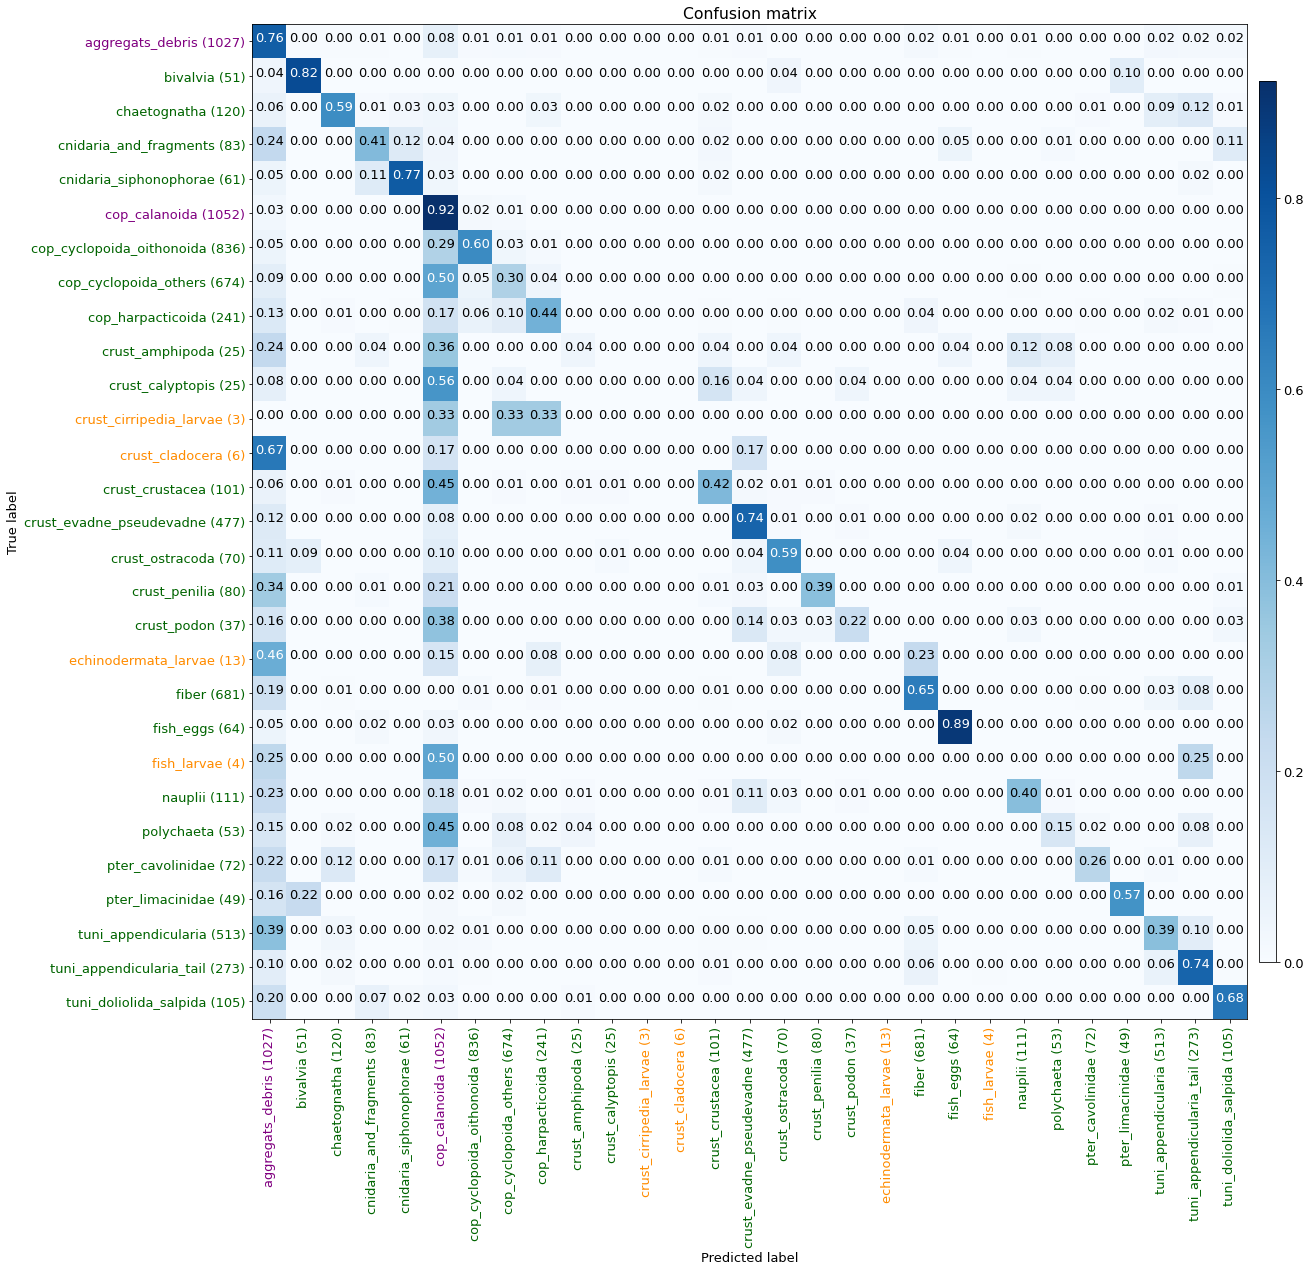

In [42]:
GMeanRecalls=[]
AverageAccuracies=[]
ClassBalanceAccuracies=[]

fold = 'manual'


model_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

model = tf.keras.models.load_model(
                                    model_filename,
                                   compile=False
                                    )

test_iterator = MyCustomImageDataGenerator(X_test_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                                   datagen=validation_gen, 
                                                   feature_1_df=X_features_test_df, 
                                                  batch_size=1, 
                                                  shuffle=False,
                                                 target_size=IMG_SIZE,
                                                 color_mode= COLOR_MODE)


test_prob=model.predict(test_iterator)
test_pred = test_prob.argmax(axis=1).tolist()
test_true = test_iterator.classes

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


# Confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred) 

confusionmatrix_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-confusion_matrix-test_set-fold_{fold}.png'
fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig(confusionmatrix_filename,bbox_inches="tight")


#average accuracy
AverageAccuracies.append(accuracy_score(test_true,test_pred))

# geometric average of recall
GMeanRecalls.append(computeGeometricAverageOfRecall(test_true, test_pred))

# class balance accuracy
ClassBalanceAccuracies.append(calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames))



In [43]:
display(GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies)

keys = ['manual']

vals = np.array([GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies])

score_dict = dict(zip(keys, zip(*vals)))

display(score_dict)

z = {'Evaluation_scores':("Geometric_Average_of_Recalls","Average_Accuracy", "Class_Balance_Accuracy"), **score_dict}

display(z)

display(pd.DataFrame.from_dict(z))

EVALUATION_SCORE_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-evaluation_score-val_sets.csv'
pd.DataFrame.from_dict(z).to_csv(EVALUATION_SCORE_filename, index=None)

[0.0]

[0.6228463877226003]

[0.39816393177337417]

{'manual': (0.0, 0.6228463877226003, 0.39816393177337417)}

{'Evaluation_scores': ('Geometric_Average_of_Recalls',
  'Average_Accuracy',
  'Class_Balance_Accuracy'),
 'manual': (0.0, 0.6228463877226003, 0.39816393177337417)}

,Evaluation_scores,manual
0,Geometric_Average_of_Recalls,0.000000
1,Average_Accuracy,0.622846
2,Class_Balance_Accuracy,0.398164


Found 6907 image filenames belonging to 29 classes.
Counter({5: 1052, 0: 1027, 6: 836, 19: 681, 7: 674, 26: 513, 14: 477, 27: 273, 8: 241, 2: 120, 22: 111, 28: 105, 13: 101, 3: 83, 16: 80, 24: 72, 15: 70, 20: 64, 4: 61, 23: 53, 1: 51, 25: 49, 17: 37, 9: 25, 10: 25, 18: 13, 12: 6, 21: 4, 11: 3})
['aggregats_debris', 'bivalvia', 'chaetognatha', 'cnidaria_and_fragments', 'cnidaria_siphonophorae', 'cop_calanoida', 'cop_cyclopoida_oithonoida', 'cop_cyclopoida_others', 'cop_harpacticoida', 'crust_amphipoda', 'crust_calyptopis', 'crust_cirripedia_larvae', 'crust_cladocera', 'crust_crustacea', 'crust_evadne_pseudevadne', 'crust_ostracoda', 'crust_penilia', 'crust_podon', 'echinodermata_larvae', 'fiber', 'fish_eggs', 'fish_larvae', 'nauplii', 'polychaeta', 'pter_cavolinidae', 'pter_limacinidae', 'tuni_appendicularia', 'tuni_appendicularia_tail', 'tuni_doliolida_salpida']
                           precision    recall  f1-score   support

         aggregats_debris       0.66      0.83      0.74 

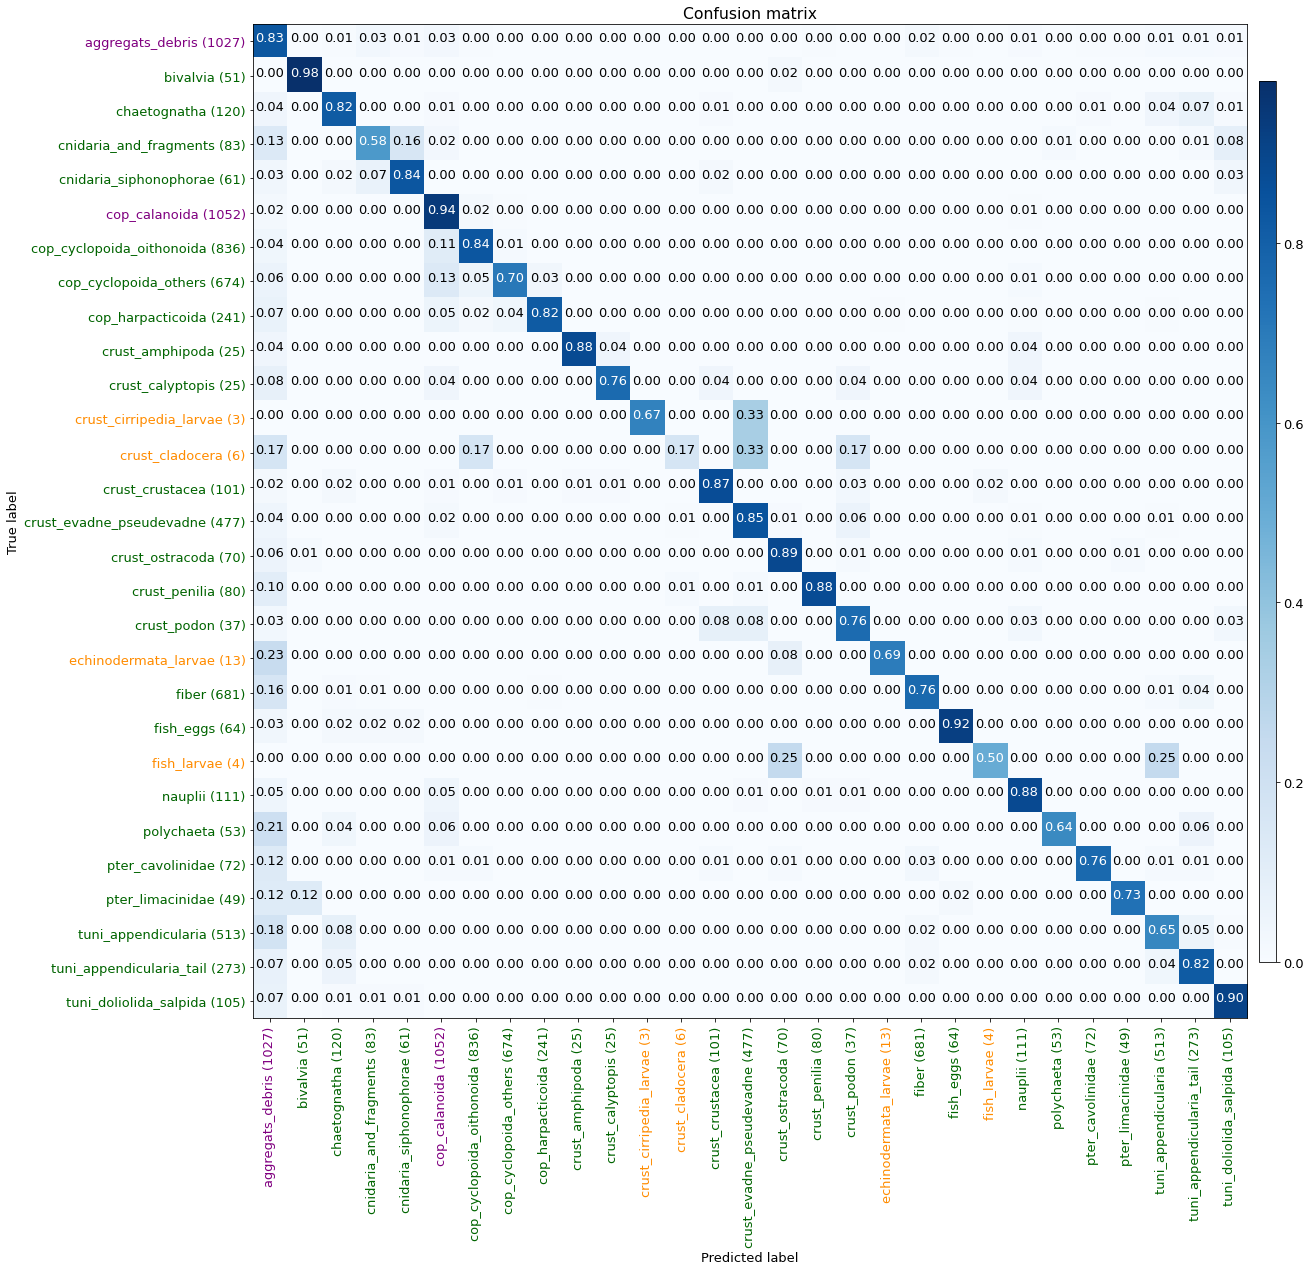

In [35]:
GMeanRecalls=[]
AverageAccuracies=[]
ClassBalanceAccuracies=[]

fold = 'manual'


model_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'

model = tf.keras.models.load_model(
                                    model_filename,
                                   compile=False
                                    )

test_iterator = MyCustomImageDataGenerator(X_test_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                                   datagen=validation_gen, 
                                                   feature_1_df=X_features_test_df, 
                                                  batch_size=1, 
                                                  shuffle=False,
                                                 target_size=IMG_SIZE,
                                                 color_mode= COLOR_MODE)


test_prob=model.predict(test_iterator)
test_pred = test_prob.argmax(axis=1).tolist()
test_true = test_iterator.classes

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)

# Accuracy, Precision, Recall, F1 score
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

REPORT_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-classification_report-test_set-fold_{fold}.csv'
df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
df_classification_report.to_csv(REPORT_filename)


# Confusion matrix
confusion_mtx = confusion_matrix(test_true, test_pred) 

confusionmatrix_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-confusion_matrix-test_set-fold_{fold}.png'
fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig(confusionmatrix_filename,bbox_inches="tight")


#average accuracy
AverageAccuracies.append(accuracy_score(test_true,test_pred))

# geometric average of recall
GMeanRecalls.append(computeGeometricAverageOfRecall(test_true, test_pred))

# class balance accuracy
ClassBalanceAccuracies.append(calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames))



In [36]:
display(GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies)

keys = ['manual']

vals = np.array([GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies])

score_dict = dict(zip(keys, zip(*vals)))

display(score_dict)

z = {'Evaluation_scores':("Geometric_Average_of_Recalls","Average_Accuracy", "Class_Balance_Accuracy"), **score_dict}

display(z)

display(pd.DataFrame.from_dict(z))

EVALUATION_SCORE_filename = f'{LOGTIME_DIR}//{CNN_MODEL_NAME}-evaluation_score-val_sets.csv'
pd.DataFrame.from_dict(z).to_csv(EVALUATION_SCORE_filename, index=None)

[0.7421413580153438]

[0.8143911973360359]

[0.7113297222407681]

{'manual': (0.7421413580153438, 0.8143911973360359, 0.7113297222407681)}

{'Evaluation_scores': ('Geometric_Average_of_Recalls',
  'Average_Accuracy',
  'Class_Balance_Accuracy'),
 'manual': (0.7421413580153438, 0.8143911973360359, 0.7113297222407681)}

,Evaluation_scores,manual
0,Geometric_Average_of_Recalls,0.742141
1,Average_Accuracy,0.814391
2,Class_Balance_Accuracy,0.711330
